### set up

In [2]:
import os
path1 = 'C:\\Users\\BSE\\Documents\\MaxVonMylius\\GeographyGrowth\\TermPaper\\py'
path2 = 'C:\\Users\\mmyli\\Documents\\HumboldtUni\\GeographyGrowth\\Paper\\shadow_projection_2D'
path = path1 if os.path.isdir(path1) else path2
os.chdir(path)

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from shapely.affinity import translate, scale
from shapely.ops import cascaded_union
from pysolar import solar
from datetime import datetime
import math
import pytz

# Define helper functions

### Learnings:
#### Speeding up code:
- accessing coords like poly.exterior.coords is very costly
- convention: 
    - exterior should be defined counter-clockwise, 
    - interiors should be defined clockwise

In [9]:
def definedClockwise (coords):
    """
    return whether coords are defined clockwise
    """
    
    return sum([(coords[(i+1)%len(coords)][0]-coords[i][0])*(coords[(i+1)%len(coords)][1]+coords[i][1]) for i in range(len(coords))])>0

## Functions to create random Polygons

In [1087]:
def createPolygon (n_edges:int, interiors:list=[], scale:int=1, shift:tuple=(0,0), convex:bool=True, regular:bool=True) -> Polygon:
    """
    creates and returns a Polygon based on the parameters given
    Polygon coordinates are points from the unit circle
    if regular == True, then all edges have same length, and all angle are equal 

    """
    if n_edges<3:
        raise ValueError('n_edges edeges must be at least 3 to create a polygon. n_edges was '+ str(n_edges))
    
    splitAt = np.random.randint(n_edges+1)
    scaleNonConvex = [1 for n in range(n_edges)] if convex else [(np.random.random()*2+0.5)/2.5 for n in range(n_edges)]
    rndm = [np.random.random()+0.1 for n in range(n_edges)]
    scaleNonReguar = [n/n_edges for n in range(n_edges)] if regular else [sum(rndm[:n])/sum(rndm) for n in range(n_edges)]
    # print(scaleNonReguar)
    coords = [(\
        shift[0]+scaleNonConvex[i]*scale*math.sin(scaleNonReguar[i] * 360 * math.pi / 180 ),\
        shift[1]+scaleNonConvex[i]*scale*math.cos(scaleNonReguar[i] * 360 * math.pi / 180 ) \
        ) for i in range(n_edges)]
    coords = coords[:splitAt] + coords[splitAt:]

    if definedClockwise(coords):
        coords.reverse()
    for interior in interiors:
        if not definedClockwise(interior):
            interior.reverse()

    return Polygon(coords, interiors)    

In [1088]:
def createConvexPolygon (n_edges:int, interiors:list=[], scale:int=1, shift:tuple=(0,0), regular:bool=True) -> Polygon:
    """
    creates and returns a Polygon based on the parameters given
    Polygon coordinates are points from the unit circle
    if regular == True, then all edges have same length, and all angle are equal 

    """
    return createPolygon(n_edges=n_edges, interiors=interiors, scale=scale, shift=shift, convex=True, regular=regular)
    

In [1093]:
def createPolygonWithInteriors(n_edges:int=3, n_interiors:int=0, n_edges_interiors:int=3, regular:bool=True, convex:bool=True, convexInteriors:bool=True, max_iterations:int=10) -> Polygon:
    if regular:
        return createPolygon(n_edges, \
            interiors=[[\
            createPolygon(n_edges=n_edges_interiors, scale=1/(n*5), shift=(1/(n+2)*(i+1)-0.5*n/(n+1),0), \
                regular=regular, convex=convexInteriors).exterior for i in list(range(n))] for n in [n_interiors]][0],\
            convex=convex)
    
    # randomly create wholes within shape
    interiors = []
    interiorCenterCoords = []
    interiorScale = 1/(.25+math.log(n_interiors+3))
    interiorScales = [interiorScale]

    r = np.random.random()
    n_edges_irregular = n_edges#int(2*(n_edges-3)*r+3)
    poly = createPolygon(n_edges_irregular, regular=regular, convex=convex)
    extCoords = poly.exterior.coords
    maxmax=2**n_interiors * 1000
    m=0
    for j in range(n_interiors):
        iteration = 0
        while len(interiors)-1 < j:
            # try different points in this
            if iteration == 0:
                boundingPoly = Polygon( [( (1-interiorScale)*coord[0], (1-interiorScale)*coord[1] ) for coord in extCoords] )
                interiorBounds = [ Polygon([ ( (1+interiorScale)*interiorScales[i]*(coord[0] - interiorCenterCoords[i][0]) + interiorCenterCoords[i][0], \
                    (1+interiorScale)*interiorScales[i]*(coord[1] - interiorCenterCoords[i][1]) + interiorCenterCoords[i][1] ) \
                    for coord in interiors[i]]) for i in range(len(interiors))]
                # bounds = (minx, miny, maxx, maxy)
                bounds = boundingPoly.bounds
            #
            
            # find random point within Polygon (but at some distance of edges)
            p = Point(bounds[0]-1, bounds[1]-1)
            
            while not (boundingPoly.contains(p) and not any([ib.contains(p) for ib in interiorBounds])):
                p = Point((bounds[2]-bounds[0])*np.random.random()+bounds[0], (bounds[3]-bounds[1])*np.random.random()+bounds[1])
                
                m+=1
                if maxmax == m:
                    print("bounds",bounds)
                    print("boundingPoly",list(boundingPoly.exterior.coords))
                    print("p.coords", p.coords[0])
                    print("boundingPoly.contains(p)",boundingPoly.contains(p))
                    print("interiorBounds",interiorBounds)
                    print("m",m)
                    gpd.GeoSeries([poly, boundingPoly] + interiorBounds).plot(cmap="viridis", alpha=0.4, edgecolor="black")
                    return
            
            r = np.random.random()
            n_edges_interiors_irregular = int(2*(n_edges_interiors-3)*r+3)
            interior = createPolygon(n_edges=n_edges_interiors_irregular, scale=interiorScale, shift=list(p.coords)[0], regular=regular, convex=convexInteriors).exterior
            
            if poly.contains(interior):
                interiorCoords = list(interior.coords)
                if not definedClockwise(interiorCoords):
                    interiorCoords.reverse()
                interiors.append(interiorCoords)
                poly = Polygon(extCoords, [x for x in interiors])
                interiorScales.append(interiorScale)
                interiorCenterCoords.append(p.coords[0])
                iteration = 0
            else:
                if iteration == max_iterations - 1:
                    interiorScale *= 0.9*(1-m/maxmax)**2 
                iteration = (iteration+1) % max_iterations
        #
    #
    return poly


In [8]:
def noDoubleCoords (coords):
    """
    Function that clean coordinates such a coordinate that directly follows itself is removed
    """
    return [coords[i] for i in range(len(coords)) if not coords[i] == coords[(i+1)%len(coords)]]

In [1039]:
def projectTriangleShadow (coords:shapely.coords.CoordinateSequence or list, vector:tuple)->list:
    """
    Inputs:
    coords = list of tuples of which the first three are taken into account
    vector = tuple indicating a vector from origion (0,0) to point(vector)
    Idea: 
    A triangle that is projected a long a vector of positive length is alwas transformed into a pentagon
    which consits of all points of orignal triangle and points of triangle shifted with vector 
    excluding one point (the one not left or rightmost in angle direction) from origanal triangle
    if that point is most fast towards vector direction out of the three points of that orig triangle
    else exclude that point from the shifted triangle
    """
    
    if(not len(coords) == 3 and not len(set(coords))==3):
        coords = list(set(coords))
        if(not len(coords)==3):
            raise ValueError("coords provided to triangle projectTriangleShadow are not of length 3:",len(coords))

    # check how far the coordinates are left or right of base vector 
    offsetOrthogonal = [(coords[i][0])*(vector[1])-(coords[i][1])*(vector[0]) for i in range(3)]
    minI = offsetOrthogonal.index(min(offsetOrthogonal))
    maxI = offsetOrthogonal.index(max(offsetOrthogonal))
    midI = 3 - maxI - minI
    
    # add those coordinates that are left and right most of original and shifted triangle 
    shadowCoords = [\
        (coords[minI][0],coords[minI][1]),\
        (coords[minI][0]+vector[0],coords[minI][1]+vector[1]),\
        (coords[maxI][0]+vector[0],coords[maxI][1]+vector[1]),\
        (coords[maxI][0],coords[maxI][1]),\
        ]
    
    # check if midI coord lies on the side of half space spanned between minI and maxI coords into which the vector points
    midISide = (coords[midI][0]-coords[minI][0])*(coords[maxI][1]-coords[minI][1]) - \
        (coords[midI][1]-coords[minI][1])*(coords[maxI][0]-coords[minI][0])\
        >0
    vectorSide = \
        (vector[0])*(coords[maxI][1]-coords[minI][1]) - \
        (vector[1])*(coords[maxI][0]-coords[minI][0])\
        >0
    
    if not midISide == vectorSide:
        shadowCoords.append((coords[midI][0], coords[midI][1]))
    else:
        shadowCoords.insert(2, (coords[midI][0]+vector[0], coords[midI][1]+vector[1]))

    return Polygon(shadowCoords)




In [1114]:
def splitPolygonToPolygonsWithoutInteriors (poly:Polygon, plot=True) -> list:
    """
    convert any polygon to array of polygons that do not cotaining any interiors
    
    All coord rings are made counter-clockwise

    Assumption: 
    for each polygon with interiors there exist an interior with points j and j0 for j != j0
    that you can connect with a valid line from to j the exterior point k and from j0 to k0 for k != k0
    """
    interiors = poly.interiors
    # early return if no interiors
    if len(interiors) == 0:
        return [poly]
    
    polyExterior = poly.exterior
    extCoords = noDoubleCoords(polyExterior.coords)
    interiorsCoords = [noDoubleCoords(interior.coords) for interior in interiors]
    
    if definedClockwise(extCoords):
        extCoords.reverse()
                        
    i = 0
    while i < len(interiors):
        if not definedClockwise(interiorsCoords[i]):
            interiorsCoords[i].reverse()
        # store here the indices j0/j at which interior shall be split and k0/k to split exterior
        j, j0, k0, line0 = 0, -1, -1, -1
        
        # stop trying for interior i as soon as you can't connect two seperate coordinates to exterior 
        while j < len(interiorsCoords[i]) - (k0 == -1):
            k = 0
            while k < len(extCoords) and not j == j0:
                
                line = LineString([interiorsCoords[i][j], extCoords[k]])
                
                # perform multiple checks whether line from interior to exterior shall be chosen
                # line.intersects(edge) and not line.touches(edge) handles case where line partly overlays with edge but doesn't cross
                if \
                    k != k0 \
                    and poly.contains(line) \
                    and not (k0 != -1 and (line.intersects(line0) or line.touches(line0)) )\
                    and not any([line.intersects(edge) and not line.touches(edge) for edge in [LineString([interiorsCoords[i][n], interiorsCoords[i][(n+1)%len(interiorsCoords[i])]]) for n in range(len(interiorsCoords[i]))]])\
                    and not any([line.intersects(edge) and not line.touches(edge) for edge in [LineString([extCoords[n], extCoords[n+1]]) for n in range(len(extCoords)-1)]]):
                    
                    if k0 == -1:
                        j0, k0, line0 = j, k, line
                        # reset k index such that it will start with 0 in next iteration
                        k = 0
                        continue
                    
                    else:
                        # divide polygon into two parts A and B
                        intA = interiorsCoords[i][j0:j+1]
                        intB = interiorsCoords[i][j:] + interiorsCoords[i][:j0+1]
                        extA = (extCoords[k:] + extCoords[:k0+1]) if k0<k else extCoords[k:k0+1]
                        extB = (extCoords[k0:] + extCoords[:k+1]) if k0>k else extCoords[k0:k+1]

                        polyCoords = [extA + intA, extB + intB ]
                        polygons = [Polygon(coords) for coords in polyCoords]
                        
                        if(plot):
                            fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
                            gpd.GeoSeries(polygons).plot(ax=axs, alpha=0.4, cmap="viridis", edgecolor="black")
                            gpd.GeoSeries([Point(interiorsCoords[i][j]), Point(interiorsCoords[i][j0]) ]).plot(ax=axs, cmap="tab10", linewidth=3)
                            gpd.GeoSeries([Point(extCoords[k]), Point(extCoords[k0]) ]).plot(ax=axs, cmap="tab10", linewidth=3)
                            gpd.GeoSeries([line, line0]).plot(ax=axs, cmap="tab10", linewidth=3)
                            for x, y, label in zip([extCoords[x][0] for x in range(len(extCoords))], [extCoords[x][1] for x in range(len(extCoords))], [str(x) for x in range(len(extCoords))]):
                                axs.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
                            for x, y, label in zip([interiorsCoords[i][x][0] for x in range(len(interiorsCoords[i]))], [interiorsCoords[i][x][1] for x in range(len(interiorsCoords[i]))], [str(x) for x in range(len(interiorsCoords[i]))]):
                                axs.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
                        
                        # early return if just one interior
                        if len(interiors) == 1:
                            return polygons
                        
                        #else check where to nest further
                        polygons = [Polygon(coords,[interiors[n] for n in range(len(interiors)) if not n == i and Polygon(coords).contains(interiors[n])]) for coords in polyCoords]
                        polygons = [item for sublist in [[ply] if len(ply.interiors) == 0 else splitPolygonToPolygonsWithoutInteriors(ply,plot=plot) for ply in polygons] for item in sublist]
                        return polygons
                k += 1
            j += 1
        i += 1
    #

In [13]:
def splitToValidCoordinateRings (arr) -> list:
    """
    inputs:
    arr: list of coordinate [(0,0),(1,1),...]
    Function splits list of potentially invalid coordinate rings into array valid coordinate rings 
    Such that each coordinate ring does never intersect the same coordinate twice 
    E.g. a shape like the number 8 does drawn as a line would be split into two rings (upper and lower o-shape)
    Further the functions simplifies [x,y,y,z,x] to [x,y,z]
    ### 2d0 the logic is bad! rethink that it should divide instead of splitting coord rings
    
    """
    # print("arr0", arr)
    arr = [arr[i] for i in range(len(arr)) if not arr[i] == arr[(i+1)%len(arr)]]
    # print("initail",arr)
    if len(arr)==len(set(arr)):
        # print("early return", arr)
        return [arr]
    maxEl = max(set(arr), key=arr.count)
    arr = arr[(arr.index(maxEl)+1)%len(arr):] + arr[:(arr.index(maxEl)+1)%len(arr)]
    # print("not early return",arr)
    splitIndices = [0]+[i for i, x in enumerate(arr) if x == maxEl]
    # print("splitIndices",splitIndices)
    # res = [[item for sublist in \
    #     splitToValidCoordinateRings(arr[splitIndices[i]:splitIndices[i+1]+1])\
    #     for item in sublist]\
    #     for i in range(len(splitIndices)-1)]
    validDivison = False
    i=0
    while not validDivison:
        splitIndices[i]+1
    print("res0", arr)
    res = [
        arr[splitIndices[i]:splitIndices[i+1]+1]\
        for i in range(len(splitIndices)-1)] 
    print("res1", res)
    
    res = [[a[i] for i in range(len(a)) if not a[i] == a[(i+1)%len(a)]] \
        for a in \
        res]
    # here make the split
        
    [arr for arr in res]

    print("res2",res)
    res = [b if len(b)==len(set(b)) else splitToValidCoordinateRings(b) \
        for b in \
        res]
    print("res3",res)

    # res = [b if len(b)==len(set(b)) else splitToValidCoordinateRings(b) \
    #     for b in \
    #     [[item for sublist in \
    #     arr[splitIndices[i]:splitIndices[i+1]+1]\
    #     for item in sublist]\
    #     for i in range(len(splitIndices)-1)]]

    print("res",res)
    return res

In [14]:
def addSelfIntersectingCoords(coords) -> list:
    """
    inputs:
    coords = list of coordinates
    """
    edges = [LineString(coords[k:k+2]) for k in range(len(coords) - 1)]
    # 2do check that sorted sorts in correct order
    coordsWithIntersectionPoints = \
        [item for sublist in [[coords[i]]+\
        [item for sublist in \
        [sorted(list(edges[i].intersection(edges[j]).coords),\
        key=lambda intersec: abs(coords[i][0]-intersec[0] + coords[i][1]-intersec[1]))\
        for j in range(len(edges))if not i == j and edges[i].crosses(edges[j])] \
        for item in sublist] \
        for i in range(len(coords)-1)] \
        for item in sublist]
    # print("coordsWithIntersectionPoints",coordsWithIntersectionPoints)
    return coordsWithIntersectionPoints

In [16]:
# 2do create a function that make invalid polygons valid
def makePolygonValid (poly:Polygon) -> list:
    """
    return polygon as list of valid polygons
    """
    [x for x in ]
    Polygon()

    if type(poly.boundary)==LineString or not poly.is_valid:
        # split polygon into valid parts
        coords = poly.boundary.coords # 2do maybe the intersections are not visible from points
        print("poly.boundary.coords", list(poly.boundary.coords))
        triangleList = \
            [\
                [item for sublist in \
                    triangularize(Polygon(\
                        coordRing, \
                        [[item for sublist in splitToValidCoordinateRings(addSelfIntersectingCoords(list(interior.coords))) for item in sublist] \
                        for interior in poly.interiors if Polygon(coordRing).contains(interior)]\
                    )) \
                for item in sublist]\
            for coordRing in splitToValidCoordinateRings(addSelfIntersectingCoords(coords))]
        print("after invalid shape:",triangleList)
        # return triangleList
        
    return []

SyntaxError: invalid syntax (1953581457.py, line 5)

In [1104]:
def triangularize(poly:Polygon, lvl:int=0, maxIteration:int=300, plot:bool=True) -> list:
    """
    Function recursively splits a polygon (valid, without interiors) into two parts until the initial polygon is completly divided into triangles
    it returns a list of triangle coordinates
    Inputs: 
    poly = Polygon that will be triangularized. That may Polygon may have any shape and may have multiple holes (=interiors)
    lvl indicates the deepness of the nest
    """
    # handles cases where polygon has holes
    if lvl == 0 and len(poly.interiors)>0:
        #2do validate polygon at this step
        triangleList =  \
            [item for sublist in \
                [triangularize(polyWithoutInteriors) for polyWithoutInteriors in splitPolygonToPolygonsWithoutInteriors(poly, plot)]\
            for item in sublist]
        return triangleList
    # thus from here on polygon does not have any holes by definition
    coords = noDoubleCoords(poly.exterior.coords)
    
    # early return if shape is regular triangle
    if(len(set(coords))<4):
        print("early return", [poly])
        return [poly.exterior.coords]

    line = LineString([coords[0],coords[2]])
    i,j = 0,2
    while i < len(coords):
        line = LineString([coords[i],coords[j%len(coords)]])
        if(j < len(coords)):
            if poly.contains(line):
                coordRings = [coords[i:j+1], coords[i:i+1]+coords[j:]]
                coordRings = [coords[i:j+1], coords[:i+1]+coords[j:]]\
                    if i<j else \
                    [coords[j:i+1], coords[:j+1]+coords[i:]]
                
                listOfCoordRings = []
                for coordRing in coordRings:
                    if len(coordRing)>3:
                        res = triangularize(poly=Polygon(coordRing), lvl=lvl+1,maxIteration=maxIteration, plot=plot)
                    else:
                        res = [coordRing]
                    # print("res",res)
                    listOfCoordRings.extend(res)
                
                if(plot and lvl==0):
                    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
                    gpd.GeoSeries([poly]).plot(ax=axs, color = "white", edgecolor="black", linewidth=4)
                    gpd.GeoSeries([Polygon(x) for x in listOfCoordRings]).plot(ax=axs, alpha=0.6, cmap = "viridis", edgecolor="black")
            
                return listOfCoordRings
            j += 1
            #
        else:
            i += 1
            j = i+2
        #
    #
    raise KeyError("triangularize did not return anything. Check if coorect input was given.", i, j, coords)
    #
#

### Create examplary polygons to test functions on.

In [18]:
# create some polygons to test functions
polygon_1 = Polygon([(0, 0), (0, 3), (5, 3), (2, 4), (6, 4), (6, 0)], [[(1, 1), (1.5, 1), (1.5, 1.5)], [(2, 1), (2.5, 1), (2.5, 1.5)]])
poly=polygon_1
poly11 = Polygon([(-.5,-.5), (0,.5), (.5,-.5)], [[(-0.1,-0.1),(0.1,0.1),(0.1,-0.1)]])
poly3 = createPolygonWithInteriors(n_edges=5, n_interiors=1, n_edges_interiors=3, regular=True)
poly4 = createPolygonWithInteriors(n_edges=5, n_interiors=1, n_edges_interiors=3, regular=False)
poly5 = createPolygonWithInteriors(n_edges=5, n_interiors=2, n_edges_interiors=4, regular=True)
poly6 = createPolygonWithInteriors(n_edges=5, n_interiors=2, n_edges_interiors=4, regular=False)
poly7 = createPolygonWithInteriors(n_edges=5, n_interiors=3, n_edges_interiors=4, regular=True)
poly8 = createPolygonWithInteriors(n_edges=5, n_interiors=3, n_edges_interiors=4, regular=False)
convexWithInterior = [createPolygonWithInteriors(n_edges=3+np.random.randint(10), n_interiors=1+np.random.randint(10), n_edges_interiors=3+np.random.randint(5), regular=False) for i in range(50)]

### test splitPolygonToPolygonsWithoutInteriors function

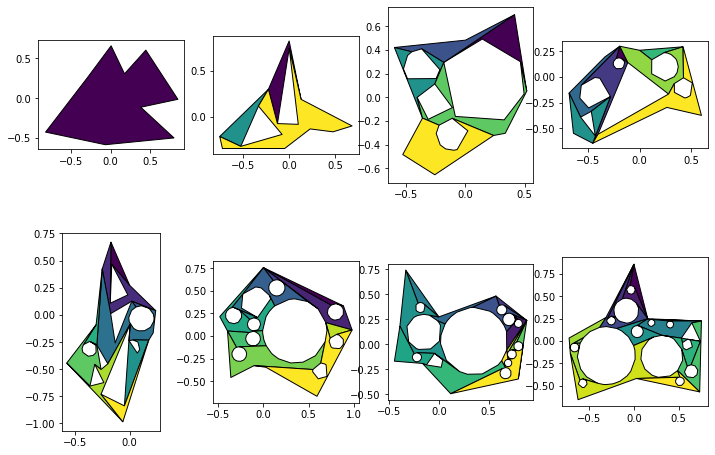

In [1115]:
polys = []
imax = 4*2
fig, axs = plt.subplots(nrows = imax//4, ncols = 4, figsize = (12,8))
for i in range(imax):
    poly = createPolygonWithInteriors(n_edges=9, n_interiors=i*2, n_edges_interiors=3+i*2, regular=False, convex=False)
    polys.append(poly)
    splitted = splitPolygonToPolygonsWithoutInteriors(poly, plot=False)
    gpd.GeoSeries(splitted).plot(ax=axs.flat[i], cmap="viridis",edgecolor="black")
    


### test triangularize function

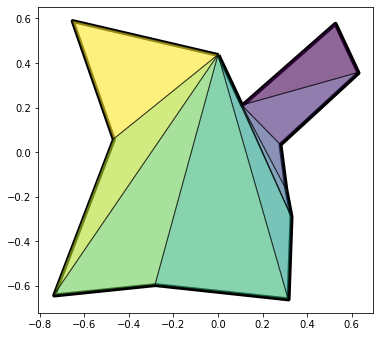

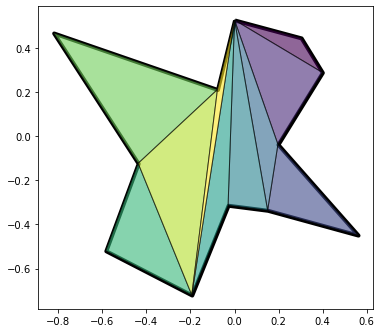

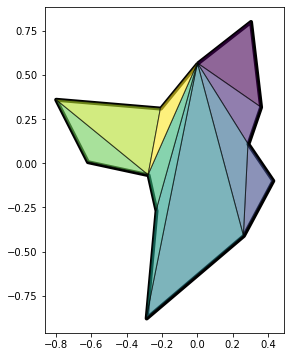

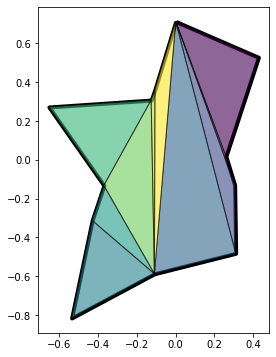

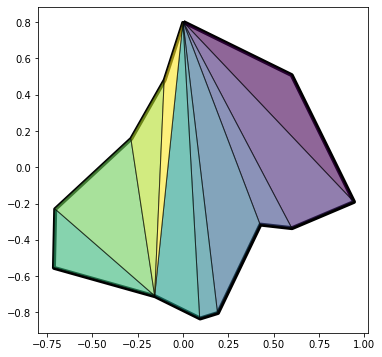

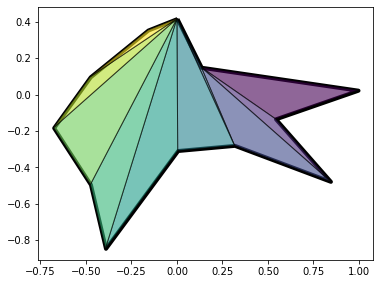

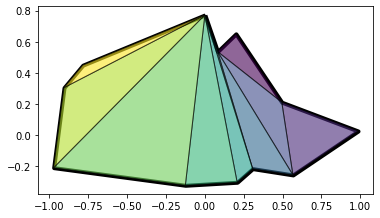

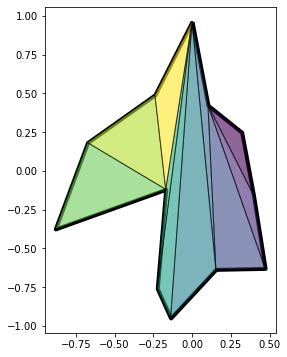

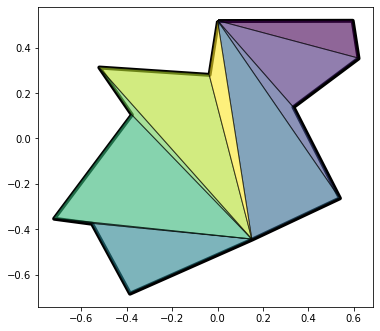

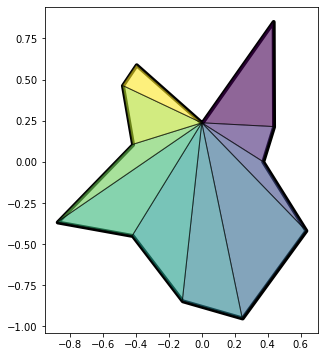

In [236]:
for i in range(10):
    b = createPolygon(12, regular=False, convex=False)
    a = triangularize(b, plot=True)
    if not len(a) == len(b.exterior.coords)-3:
        print("not")
        triangularize(b, plot=True)
        break

### test projectTriangleShadow function

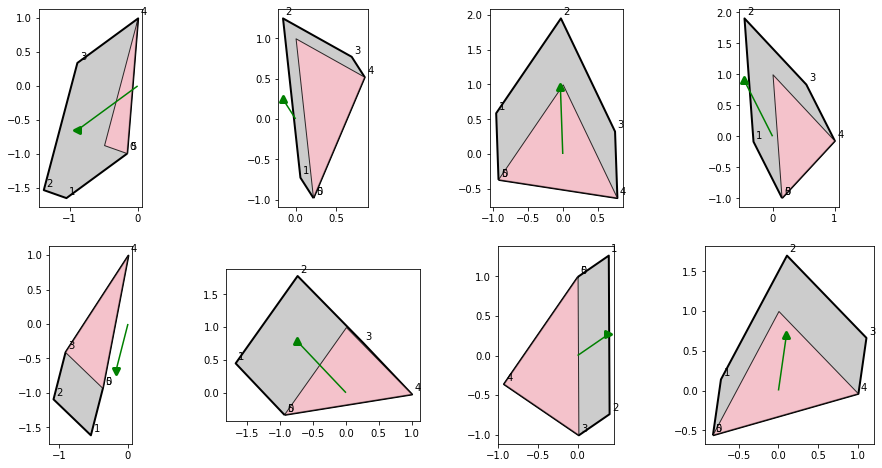

In [1118]:
imax = 4*2
fig, axs = plt.subplots(nrows = imax//4, ncols = 4, figsize = (16,8))
for i in range(imax):
    triangle=createPolygon(3, regular=False)
    vector = ((np.random.random()*2-1),(np.random.random()*2-1))
    shadow = projectTriangleShadow(triangle.exterior.coords, vector)
    gpd.GeoSeries([shadow]).plot(ax=axs.flat[i], color="#cccccc", linewidth=2, edgecolor="black")
    gpd.GeoSeries([triangle]).plot(ax=axs.flat[i], alpha=0.8,color="pink",edgecolor="black")
    gpd.GeoSeries([LineString([(0,0),vector])]).plot(ax=axs.flat[i], edgecolor="green")
    arrow =  (">" if vector[0]>0 else "<") if abs(vector[0])>abs(vector[1]) else ("^" if vector[1]>0 else "v")
    gpd.GeoSeries([Point(vector)]).plot(ax=axs.flat[i], color="green", linewidth=3, marker = arrow)
    for x, y, label in zip([shadow.exterior.coords[x][0] for x in range(len(shadow.exterior.coords))], [shadow.exterior.coords[x][1] for x in range(len(shadow.exterior.coords))], [str(x) for x in range(len(shadow.exterior.coords))]):
        axs.flat[i].annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

### test all together
1. splitPolygonToPolygonsWithoutInteriors
2. triangularize
3. projectTriangleShadow

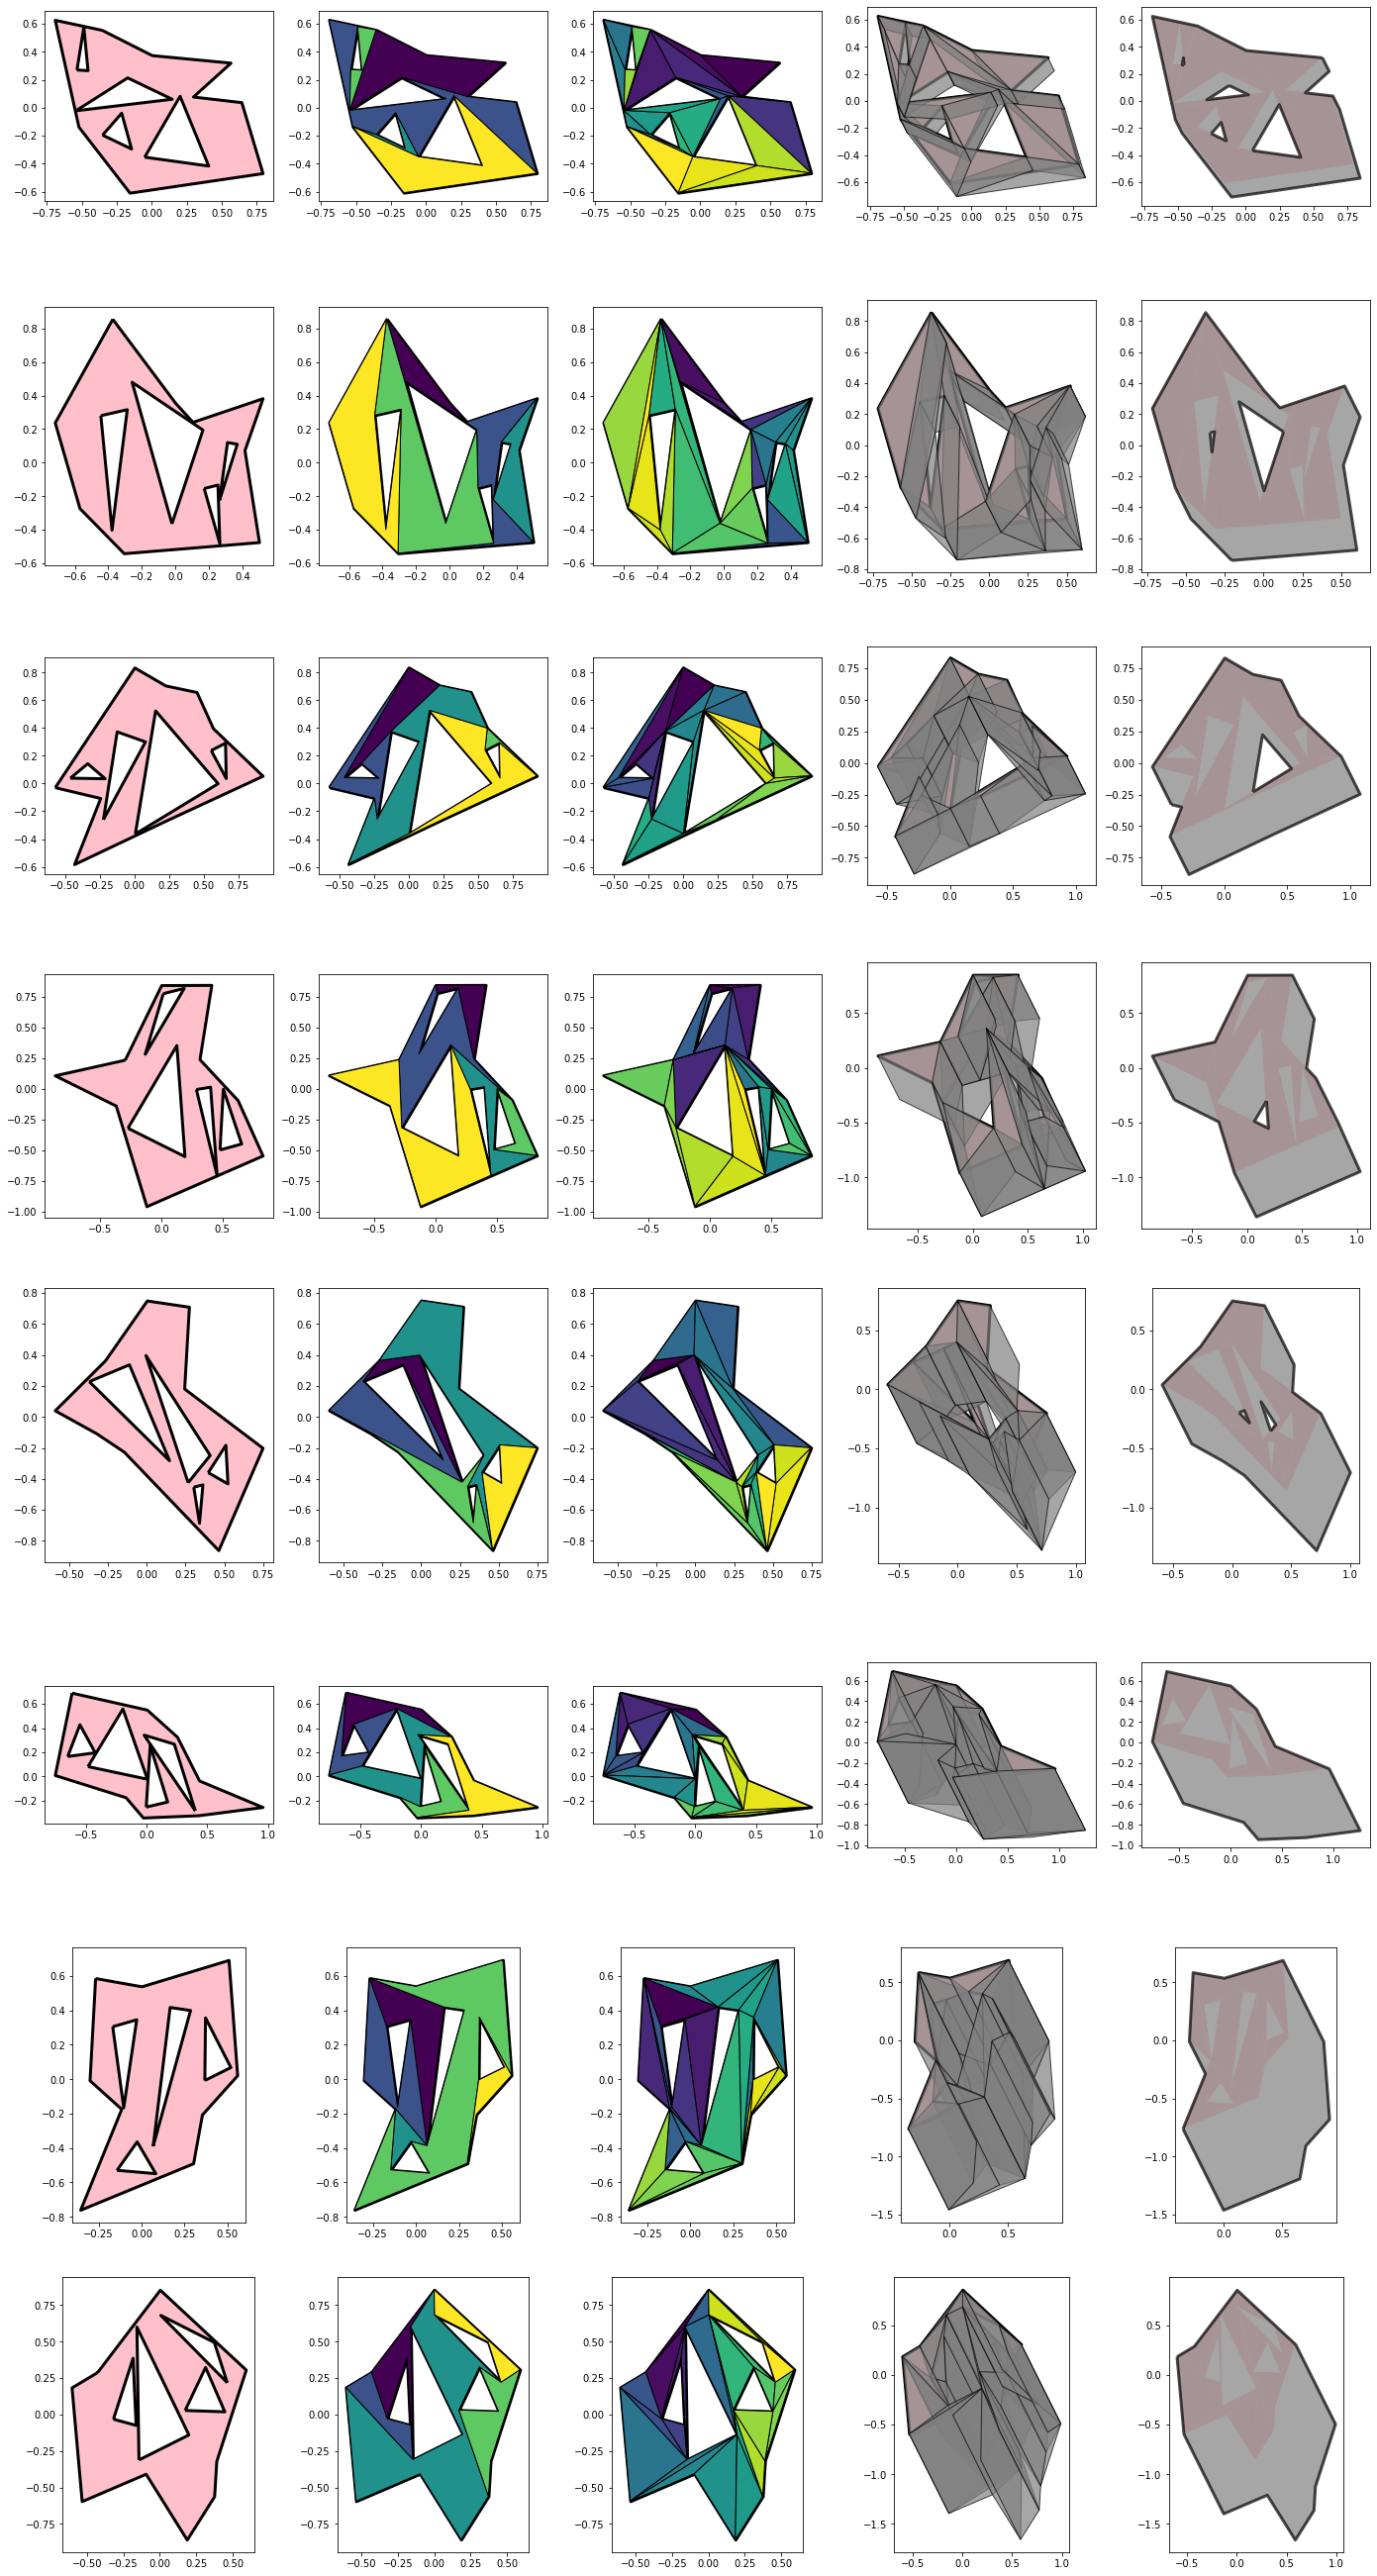

In [1119]:
polys = []
imax = 8
fig, axs = plt.subplots(nrows = imax, ncols = 5, figsize = (24,imax*6))
for i in range(imax):
    shaodowVector = (i/20+0.05, -i/10-0.1) 
    poly = createPolygonWithInteriors(n_edges=9, n_interiors=4, n_edges_interiors=3, regular=False, convex=False)
    polys.append(poly)
    splitted = splitPolygonToPolygonsWithoutInteriors(poly, plot=False)
    triangleCoords = [item for sublist in [triangularize(x, plot=False) for x in splitted] for item in sublist]
    triangles = [Polygon(x) for x in triangleCoords]
    shadows = [projectTriangleShadow(x, shaodowVector) for x in triangleCoords]
    shadow_union = cascaded_union(shadows)

    gpd.GeoSeries([poly]).plot(ax=axs.flat[i*5+0], color = "pink", edgecolor="black", linewidth=3)
    gpd.GeoSeries([poly]).plot(ax=axs.flat[i*5+1], color = "white", edgecolor="black", linewidth=3)
    gpd.GeoSeries(splitted).plot(ax=axs.flat[i*5+1], cmap="viridis",edgecolor="black")
    gpd.GeoSeries([poly]).plot(ax=axs.flat[i*5+2], color = "white", edgecolor="black", linewidth=3)
    gpd.GeoSeries(triangles).plot(ax=axs.flat[i*5+2], cmap="viridis",edgecolor="black")
    gpd.GeoSeries([poly]).plot(ax=axs.flat[i*5+3], color = "pink", edgecolor="black", linewidth=3)
    gpd.GeoSeries(shadows).plot(ax=axs.flat[i*5+3], alpha=0.7, color = "grey",edgecolor="black")
    gpd.GeoSeries(triangles).plot(ax=axs.flat[i*5+4], color = "pink")
    gpd.GeoSeries([shadow_union]).plot(ax=axs.flat[i*5+4], alpha=0.7, color = "grey",edgecolor="black", linewidth=3)



In [ ]:
addSelfIntersectingCoords([(0.0, 0.0), (2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0), (2.0, 2.5)])

coordsWithIntersectionPoints [(0.0, 0.0), (2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0)]


[(0.0, 0.0),
 (2.25, 2.0),
 (2.5, 2.5),
 (0.0, 3.0),
 (5.0, 3.0),
 (0.0, 0.0),
 (0.0, 3.0)]

In [ ]:
splitToValidCoordinateRings([(0.0, 0.0), (2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0), (2.0, 2.5)])

arr0 [(0.0, 0.0), (2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0), (2.0, 2.5)]
res0 [(2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0), (2.0, 2.5), (0.0, 0.0)]
res1 [[(2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (0.0, 3.0), (2.0, 2.5), (0.0, 0.0)]]
res2 [[(2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (0.0, 3.0), (2.0, 2.5)]]
res3 [[(2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (0.0, 3.0), (2.0, 2.5)]]
res [[(2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (0.0, 3.0), (2.0, 2.5)]]


[[(2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0)],
 [(0.0, 0.0), (0.0, 3.0), (2.0, 2.5)]]

In [184]:
def getEdgesFromCoords (coords:list):
    """
    Create Linestrings between each coords and the following coordinate (last is connected to first) 
    Returns Linestrings in List
    """
    # 2do: Problem! there might be groups of edges (hole in the shape) 
    # thus not all points shall be connected
    # only points within groups of edges
    # len(list(geom.interiors)) == 0 # no holes
    # Solve by taking a list of coords as Input and 
    # return [[LineString( ???(coords if coords[0] == coords[-1] else coords + [coords[0]])???[i:i+2]) for i in range(len(coords) - 1)] for coords in coordSets]
    if coords[0] != coords[-1]:
        coords = coords + [coords[0]]
    return [LineString( coords[i:i+2]) for i in range(len(coords) - 1)]
#

In [81]:
def isDescending (edgeCoords:list):
    if(edgeCoords[0][0] == edgeCoords[1][0]):
        return edgeCoords[0][1] > edgeCoords[1][1]
    else: 
        return edgeCoords[0][0] > edgeCoords[1][0]
#

In [82]:
def createLinesFromCoords (coords:list):
    """
    Create Linestrings between each coords and the following coordinate (last is connected to first) 
    Returns Linestrings in List
    ATTENTION: IT SEEMS LIKE THE OLD VERSION DIDNT CONNECT THE LAST TO FIRST COORDINATE (NOT CLOSING POLYGON). FOR ANY REASON?
    ATTENTION: WHY ARE WE SORTING?
    ATTENTION: IS IT A PROBLEM TO GET RID OF DUPLICATE COORDINATES IN CASE THERE ARE WEIRDLY SHAPED POLYGONS?
    """
    # ATTENTION: IT SEEMS LIKE THE OLD VERSION DIDNT CONNECT THE LAST TO FIRST COORDINATE (NOT CLOSING POLYGON)
    # coords = list(set(coords))
    coords.sort(reverse = isDescending(coords))
    # lines = []
    # for coordIndex in range(len(coords) - 1):
        # newLine = LineString([coords[coordIndex], coords[coordIndex + 1]])
        # lines.append(newLine)
    # return lines
    return [LineString( (coords if coords[0] == coords[-1] else coords + [coords[0]])[i:i+2]) for i in range(len(coords) - 1)]
#

In [83]:
# def splitLineWithEdges (line:LineString, edges:list):
#     """OLD FUNCTION THAT IS NOT USEFULL AS IT IS"""
#     # loop through all edge to evaluate whtether there has been an intersection
#     lineCoords = list(line.coords)
#     for edge in edges:
#         if(line.intersects(edge)):
#             # if there has been an intersection cut edge in two parts
#             lineCoords += list(edge.intersection(line).coords)
#     return edges
#

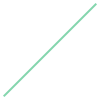

In [219]:
LineString([(1,2), (3,4)])

In [224]:
l = list([[ LineString([(1,2), (3,4) ]) ]])
l
[item for sublist in l for item in sublist]

In [ ]:
def splitEdgeAlongLine (edge:LineString, line:LineString):
    if(edge.crosses(line)):
        # if there has been an intersection cut edge in two parts
        edgeIntersectionCoords = list(edge.intersection(line).coords)
        edgeCoords = list(set(list(edge.coords) + edgeIntersectionCoords))
        splittedEgdeParts = createLinesFromCoords(edgeCoords)
        return splittedEgdeParts
    else: 
        return [edge]
#

In [228]:
lines = []
for i in range(10):
    lines.append(LineString([(np.random.random(2)), (np.random.random(2))]))


In [295]:
for i in range(5000):
    [item for sublist in [[[y]] if y==1 else [] for y in np.random.randint(0,2,1000) if y==1] for item in sublist]

In [302]:
[item for sublist in [[1,2],[3,4],[]] for item in sublist]

[1, 2, 3, 4]

In [304]:
[edge for edge in [0,2,3,4,5] if edge not in [1,2,3,4]]

[0, 5]

In [296]:
for i in range(5000):
    [item for item in [[y] if y==1 else [] for y in np.random.randint(0,2,1000) if y==1]]

In [235]:
def splitEdgesAlongLine (edges:list, line:LineString, plot:bool = False):
    """
    Splits edges that cross a line, remove orignal edge from edges and add the seperate edge
    return potentially modified list of edges
    """
    oldEdges = edges
    # loop through all edges to evaluate whtether there has been an intersection
    edges = [item for sublist in [splitEdgeAlongLine(edge, line) for edge in edges] for item in sublist]
    [x for x in array if x==x ]

    if(len(edges)<len(oldEdges)-1):
        print("edges removed!")
    
    if(plot):
        fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        gpd.GeoSeries(oldEdges).plot(ax=axs, color="red")
        gpd.GeoSeries(edges).plot(ax=axs, color="blue")
        edgesToAdd = [edge for edge in edges if edge not in oldEdges]
        gpd.GeoSeries(edgesToAdd).plot(ax=axs, color="green")
        gpd.GeoSeries([line]).plot(ax=axs, color="black")
        fig.suptitle('Spliting (green) edge at (black) line')    

    return edges
#

In [85]:

def angleToNorth (point1:tuple = (0,0), point2:tuple = (0,0)):
    """
    point1 and point2 each must be a tuple of point coords eg. (0,1)
    return angle to north ((0,0) to (0,1))
    """
    xDiff = point2[0] - point1[0]
    yDiff = point2[1] - point1[1]
    
    if(xDiff == 0):
        angle = 0 if(yDiff > 0) else 180
    else:
        angle = -math.atan(yDiff / xDiff) * 180 / math.pi + (270 if(xDiff<0) else 90)
    
    return angle
#

In [15]:
def addOne (e):
    return e

In [23]:
it = 1000
arrlen = 100000

In [32]:
for i in range(it):
    l=[addOne(x) for x in range(arrlen)]

In [33]:
for i in range(it):
    l = [None]*arrlen
    for j in range(arrlen):
        l[j] = addOne(j)

In [31]:
for i in range(it):
    l=[x for x in range(arrlen)]

In [34]:
for i in range(it):
    l = [None]*arrlen
    for j in range(arrlen):
        l[j] = j

In [87]:
def plotGeometry (geometryList:list, axs = None, color:str = "", cNr:int = None, label:bool = False):
    """
    plot a list of geometries. input:
        geometryList = list of geometries
        axs = plot index, if not specified it directly plots
        color = if specified it determines the color of geometry
        cNr = (if no color) species color map ['tab20', 'Set3', 'Set1', 'tab20b', 'tab20c', 'gist_ncar'][cNr].  
    """
    
    if( type(geometryList) != list or (len(geometryList) == 0) ):
        print('can not plot geometry: no valid list of geometries provided.')
        return
    
    p = gpd.GeoDataFrame(range(len(geometryList)))
    p.columns = ['nr']
    p['geometry'] = geometryList
    cmaps = ['tab20', 'Set3', 'Set1', 'tab20b', 'tab20c', 'gist_ncar']
    if(color):
        if(color not in cmaps):
            p.plot(ax = axs, color = color, edgecolor = '#000')
        else:
            p.plot(ax = axs, cmap = color, column = 'nr')
    else:
        cmap = cmaps[cNr]
        p.plot(ax = axs, cmap = cmap, column = 'nr')
    if(axs and label):
        p.apply(
            lambda x: axs.annotate(text=x.nr, xy=x.geometry.centroid.coords[0], ha='center'), axis=1
        )
#

In [88]:

def orderPresentInArray (el1, el2, listOfLists:list):
    """
    check if el1 and el2 are included in any list within listOfLists array AND
    that el2 directly follows el1
    including possibility of [el2, ...,el1]
    returns bool
    ATTENTION: UNDERSTAND WHY WE ARE LOOKING AT NESTED ARRAY
    """
    return len(
        [x for x in listOfLists if 
         el1 in x and 
         el2 in x and 
         (
             x.index(el1) == x.index(el2) - 1 or
             (
                 x.index(el1) == len(x) - 1 and 
                 x.index(el2) == 0)
             )
         ]
        ) > 0
#

In [ ]:
def clockwiseAngle (firstAngle, secondAngle):
    """
    returns the outer angle in clockwise direction
    thus 180° if angles are equal
    """
    return (secondAngle - firstAngle + 540) % 360
#

In [89]:

def findNextVertex (currentPath:list, polygonPaths:list, verticesNetworkMatrix, vertices:list):
    """
    nested function that tries to find a path that encloses a polygon within which no other polygon lies
    idea: we only follow path in clockwise motion
    then the best way to close polygon is follow the line wich goes 
    back from which the last edge came from. 
    the angle thus needs to be maximized but still follow the clockwise definition

    currentPath needs to be at least of length 2
    currentPath entries are indices referring to a vertex

    """
    # problem: outline path is still included # idea: could be solved if always going the wrong outside way
    
    # all other vertices that are connected to this vertex
    lastVertex = currentPath[-2]
    currentVertex = currentPath[-1]
    connectedVertices = [x[0] for x in [x for x in enumerate(verticesNetworkMatrix[currentVertex]) if x[1]]]
    
    angleLastEdge = angleToNorth(vertices[lastVertex], vertices[currentVertex])
    #
    angles = np.array(list(map(
        lambda x: clockwiseAngle(
                       firstAngle = angleLastEdge, 
                       secondAngle= angleToNorth(vertices[currentPath[-1]], vertices[x])
                       ), connectedVertices)))
    nextVertex = connectedVertices[angles.argmax()]
    # check if nextVertex already followed nextVertex in a polyognPaths
    
    usedBefore = orderPresentInArray(currentVertex, nextVertex, polygonPaths)
    
    if(not usedBefore):
        # check if path is closed
        isClosed = nextVertex == currentPath[0]
        if(not isClosed):
            currentPath.append(nextVertex)
            findNextVertex(currentPath, polygonPaths, verticesNetworkMatrix, vertices)
        else:
            # append path to polygonPahts
            polygonPaths.append(currentPath)
#

# Define shadow projection for single Polygons

In [90]:
def projectShadow (geom:Polygon, height:float, lat:float, long:float, date:datetime, method:str = "manual", showPlots:bool = False):
    """
    return shadow geometry
    takes in original geometry, its height, lat, long, date-time
    method: 
        "difference" (fastest) adds buffers to edges ad substracts these polygons from hull using shapely
        "polygonize" (2nd fastest) uses shapely's 'polygonize' to derive individual polygons
        "manual" (slowest) manually programmed solution to detect individual polygons
    """

    # get list of coords
    coords = list(geom.exterior.coords)
    # get edges for ext
    edges = getEdgesFromCoords(coords)
    # add edges and coordinates of possible interiors (holes in shape)
    for interior in list(geom.interiors):
        interiorCoords = list(interior.coords)
        interiorEdges = getEdgesFromCoords(interiorCoords)
        coords += interiorCoords
        edges += interiorEdges
    
    # calculate angle between sun and earth surface at location and date
    altitude = solar.get_altitude(
        latitude_deg = lat, 
        longitude_deg = long, 
        when = date
        ) 
    # calculate direction of sunlight at location and date
    azimuth = solar.get_azimuth(
        latitude_deg = lat, 
        longitude_deg = long, 
        when = date
        )
    # length of the shadow
    shadowLengthUnitStick = 1 * math.tan( (90 - altitude) * math.pi / 180)
    shadowLength = height * shadowLengthUnitStick
    
    # remember: azimuth gives direction where sun comes from: 
    # shadow are projected in the opposite direction
    # if azimuth between 0° and 180° positive (= shadow goes east), else negative
    longShare = - math.sin((azimuth) * math.pi / 180)
    # if azimuth between 90° and 270° negative (= shadow goes south) else negative
    latShare = - math.sin((azimuth - 90) * math.pi / 180)
    
    scaleMetersToDegrees = 1 # projection already is in meters
    xoff = shadowLength * longShare / scaleMetersToDegrees
    yoff = shadowLength * latShare / scaleMetersToDegrees
    
    # shift footprint along shadow line (=shifter)
    geomShifted = translate(
        geom = geom, 
        xoff = xoff, 
        yoff = yoff
        )
    
    coordsShifted = list(geomShifted.exterior.coords)
    edgesShifted = getEdgesFromCoords(coordsShifted)
    # add edges and coordinates of possible interiors (holes in shape)
    for interior in list(geomShifted.interiors):
        interiorCoords = list(interior.coords)
        interiorEdges = getEdgesFromCoords(interiorCoords)
        coordsShifted += interiorCoords
        edgesShifted += interiorEdges
        
    # get shifters (connecting point of original geometry to respective point in projection)
    # shifters = []    
    # for coordIndex in range(len(coords)-(coords[0]==coords[-1])):
    #     shifter = LineString([coords[coordIndex], coordsShifted[coordIndex]])
    #     shifters.append(shifter)
    shifters = [LineString([coords[i], coordsShifted[i]]) for i in range(len(coords)-(coords[0]==coords[-1]))]
    
    
    # plot polygons, edges and shifters
    if(showPlots):
        fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        plotGeometry([geom], axs, "#ccccccaa")
        plotGeometry([geomShifted], axs, "#ccccccaa")
        plotGeometry(edges, axs, "blue")
        plotGeometry(edgesShifted, axs, "green")
        plotGeometry(shifters, axs, "orange")
        fig.suptitle('geom (blue), geomShifted (green) and shifters (orange)')
    
    # divide edges at each intersction with other edges
    if(method != "difference"):
        # sect intersection of shifters with geoms
        intersectionCoords = []
        shiftersToRemove = []
        shiftersToAdd = []
        # account for intersections along between geom and geomShifted with Shifters lines
        for coordIndex in range(len(coords)-1):
            
            shifter = shifters[coordIndex]
            shifterCoords = list(shifter.coords)
            
            if(geom.crosses(shifter)):
                # print('crosses geom')
                # there is a mistake here. intersection can be point only
                intersections = geom.intersection(shifter)
                # print('intersections.type' , intersections.type)
                if(intersections.type in ['LineString', 'Point']):
                    intersections = [intersections]
                for intersection in intersections: 
                    # if(intersection.type == 'Point'):
                    #     print('point only')
                    #     continue

                    # 2DO: THERE SEEMS TO BE A MISTAKE WITH intersectionCoords, check scoping 

                    intersectionCoords = list(intersection.coords)
                    shifterCoords += intersectionCoords
                    intersectionCoords += intersectionCoords
                    # split original edges along shifter 
                    edges = splitEdgesAlongLine(edges, shifter)
                
            #
            if(geomShifted.crosses(shifter)):
                # print('crosses geomShifted')
                intersections = geomShifted.intersection(shifter)
                # print('intersections.type' , intersections.type)
                if(intersections.type in ['LineString', 'Point']):
                    intersections = [intersections]
                for intersection in intersections: 
                    # if(intersection.type == 'Point'):
                    #     print('point only')
                    #     continue
                    intersectionCoords = list(intersection.coords)
                    shifterCoords += intersectionCoords
                    intersectionCoords += intersectionCoords
                    # split shifted edges along shifter 
                    edgesShifted = splitEdgesAlongLine(edgesShifted, shifter)
    
            # if the shifter has intersections with one of the two polygons        
            shifterCoords = list(set(shifterCoords))
            if(len(shifterCoords) > 2):
                shiftersToRemove.append(shifter)
                # 2DO: check whether isDescending resolves the issue of bad ordering of coordinates
                shifterCoords.sort(reverse = isDescending(shifterCoords))
                for shifterIndex in range(len(shifterCoords) - 1):
                    # print("add 1 shifter")
                    shiftersToAdd.append(
                        LineString(
                            [shifterCoords[shifterIndex], 
                             shifterCoords[shifterIndex + 1]]
                            )
                        )
                #
            #
        #
        shifters = [x for x in shifters if x not in shiftersToRemove] + shiftersToAdd
        

        # account for intersections between geom and geomShifted
        if(geom.intersects(geomShifted) and (not geom.touches(geomShifted))):
            edgesToRemove = []
            edgesToAdd = []
            for edge in edges:
                if(edge.crosses(geomShifted)):
                    # print("edge crossses---")
                    addEdges = []
                    # split edge along Edges Shifted
                    for edgeShifted in edgesShifted:
                        # if(edge.intersects(edgeShifted)): print(edge.crosses(edgeShifted), edge.intersects(edgeShifted), not edge.touches(edgeShifted))
                        if(edge.intersects(edgeShifted) and (not edge.touches(edgeShifted))):
                            addEdges = splitEdgesAlongLine([edge], edgeShifted)
                        #
                    #
                    edgesToAdd += addEdges
                    edgesToRemove.append(edge)
                    # split edgesShifted
                    edgesShifted = splitEdgesAlongLine(edgesShifted, edge)
                
                #
            edges = [x for x in edges if not x in edgesToRemove] + edgesToAdd
            #
        #

        # account for intersections in shifters (=overlaps eg. [(0,0),(2,2)] with [(1,1),(3,3)])
        # might be expensieve. do only if offset
        shiftersToRemove = []
        shiftersToAdd = []
        for shifterIndex in range(len(shifters)):
            shifter = shifters[shifterIndex]
            for otherShifter in (shifters[:shifterIndex] + shifters[shifterIndex+1:]):
                if(shifter.intersects(otherShifter) and (not shifter.touches(otherShifter))):
                    # print("intersection")
                    shifter.intersection(otherShifter)
                    shiftersToRemove.append(otherShifter)
                    shiftersToRemove.append(shifter)
                    intersectionCoords = list(shifter.intersection(otherShifter).coords)
                    newCoords = intersectionCoords + list(shifter.coords)+ list(otherShifter.coords)
                    shiftersToAdd += createLinesFromCoords(newCoords)
        shifters = [x for x in shifters if not x in shiftersToRemove] + shiftersToAdd
        
        # if(showPlots):
        #     n=0
        #     fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        #     plotGeometry(edges, axs, '', 0)
        #     plotGeometry(edgesShifted, axs, '', 1)
        #     plotGeometry(shifters, axs, '', 5)
        #     plotGeometry( list(map(
        #         lambda x: Point(x), 
        #         list(map(lambda x: list(x.coords)[0], shifters)) + list(map(lambda x: list(x.coords)[1], shifters))
        #         )), axs, '#00ffff00', 0)
        #     plotGeometry([edges[n]], axs, 'black', 5)
        #     plotGeometry([Point(edges[n].coords[0]), Point(edges[n].coords[1])], axs, '#ff0000', 5)
        #     fig.suptitle('edges after seperation at intersections (incl shifter overlap)' + str(n))
        #     n += 1 
    #
    
    allEdges = edges + edgesShifted + shifters 

    
    
    precision = 9 # round edge coordinates to prevent precision issues
    polygons = []
    if(method == "difference"):
        # convert edges to MultiLinesString 
        multiLine = shapely.geometry.MultiLineString(allEdges)
        ## Convert Lines to Polygons by applying a tiny buffer
        buf = 0.000001
        multiLine = multiLine.buffer(buf)
        ## Get outer boundary of the lines as a polygon
        boundary = multiLine.convex_hull
        ## Get a difference to generate a multipolygon
        polygons = list(boundary.difference(multiLine))
        # reapply buffer to not have cuts in the shape
        polygons = list(map(lambda x: x.buffer(buf*2), polygons))
        #
    elif(method == "polygonize"):
        allEdgesRounded = list(map(
        lambda x: LineString(list(map(
            lambda x: (round(x[0],precision), round(x[1],precision)),
            list(x.coords)
            ))),
        allEdges
        ))
    
        polygons = list(shapely.ops.polygonize(allEdgesRounded))
        
        # fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        # plotGeometry(list(polygons), axs, '#22cccc55', 0, True)
        # plotGeometry(allEdgesRounded, axs, '', 5, False)
        # fig.suptitle('allEdges after seperation at intersections')
    elif(method == 'manual'):
        # create matrix of vertex network
        vertices = []
        for edge in allEdges:
            vertices += list(map(
                lambda x: (round(x[0],precision),round(x[1],precision)), 
                edge.coords))
            # vertices += list(edge.coords)
        vertices = list(set(vertices))
        
        edgesOfVertices = [set() for _ in range(len(vertices))]
        for e in range(len(allEdges)): 
            for v1 in range(len(vertices)):
                if(vertices[v1] in list(map(
                        lambda x: (round(x[0],precision),round(x[1],precision)), 
                        allEdges[e].coords))):
                    edgesOfVertices[v1].add(e)
        
        verticesNetworkMatrix = np.zeros((len(vertices), len(vertices))) # fill with 0
        for v1 in range(len(vertices)):
            for v2 in range(len(vertices)):
                if(not v2 >= v1 and edgesOfVertices[v1].intersection(edgesOfVertices[v2])):
                    verticesNetworkMatrix[v1, v2] = 1 # lower triangle matrix
                    verticesNetworkMatrix[v2, v1] = 1 # upper trianle matrix
        # the number of polygons a vertex is included in equals
        # the number of edges connected to the point OR this number minus 1
        # does the vertice Network Matrix tell the number of polygons? no.
        
        # work the way through the matrix
        # how to know whether a point can be inlcuded in another polygon?
        # for each step the angle needs to be calculated
        # check wheter path has been taken already:
        # by checking of the in the vertices path list,
        #   the vertices is included
        #   and if its directly followed by the other edge 
        
        polygonPaths = []
        for v0 in range(len(vertices)):
            connectedVertices = [x[0] for x in [x for x in enumerate(verticesNetworkMatrix[v0]) if x[1]]]
            for v1 in connectedVertices:
                usedBefore = orderPresentInArray(v0, v1, polygonPaths)
                if(not usedBefore):
                    findNextVertex([v0, v1], polygonPaths, verticesNetworkMatrix, vertices)
        
        
        for polyPath in polygonPaths:
            poly = Polygon(list(map(lambda x: vertices[x], polyPath )))
            polygons.append(poly.buffer(0))

        # fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        # plotGeometry(list(polygons), axs, '#22cccc55', 0, True)
        # plotGeometry(allEdges, axs, '', 5, False)
        # fig.suptitle('allEdges after seperation at intersections')
    else:
        raise ValueError('unknown method. use manual, polygonize or difference.')
    #
    
    
    shadowPolygons = []
    sunnyPolygons = []
    
    for poly in polygons:
        
        inShadow = False
        # take a random point from polygon and check if in shadow
        point = shapely.wkt.loads(poly .representative_point().wkt)
        if(geom.contains(point) | geomShifted.contains(point)):
            # print("in original")
            inShadow = True
        else:
            # print("not in original")
            pointCoords = list(point.coords)[0]
            shifter = LineString([
                pointCoords, 
                (pointCoords[0]-xoff, pointCoords[1]-yoff)
                ])
            if(shifter.intersects(geom)):
                inShadow = True
            #
        # print("inShadow", inShadow)
        # fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        # plotGeometry([poly ], axs, ["#ffff0033", "#cccccccc"][inShadow])
        # fig.suptitle('new polygon in sunlight (yellow) or shadow (grey)')

        if(inShadow):
            shadowPolygons.append(poly)
        else:
            sunnyPolygons.append(poly)
        #

    
    # merge individual shadow polygons to one shadow geometry
    shadow = shapely.ops.cascaded_union(shadowPolygons)
    
    correctlySpecified = (shadow.covers(geom) and shadow.covers(geomShifted)) or (
        shapely.ops.cascaded_union([geom.difference(shadow), geomShifted.difference(shadow)]).area < geom.area / 10000 # allow minor tolerance
        )
    if(not correctlySpecified):
        shadow = shapely.ops.cascaded_union([shadow, geom, geomShifted])
    
    if(showPlots):
        fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        gpd.GeoSeries([shadow]).plot(ax=axs, color = ['#ff7777', '#aaffaa'][correctlySpecified])
        if(len(sunnyPolygons)): gpd.GeoSeries(sunnyPolygons).plot(ax=axs, color="#ffff0033")
        gpd.GeoSeries(edges).plot(ax=axs, color="blue")
        gpd.GeoSeries(edgesShifted).plot(ax=axs, color="green")    
        gpd.GeoSeries(shifters).plot(ax=axs, color="orange")
        fig.suptitle('final shadow and sunlight polygons')
    
    return (shadow)
    



# Execute shadow projection for multiple polygons
## Possible improvements:
Don't loop through geodataframe to project shadow for each row but use a faster methods 
    (https://towardsdatascience.com/how-to-make-your-pandas-loop-71-803-times-faster-805030df4f06e) 

In [91]:
# %% loop through

# Month day combinations
filenames = ["Gebaeude_Hoehen_Phase1", "Gebaeude_Hoehen_Phase2"]
dates = [[12,21], [3,21], [6,21], [9,21]]
hours = [18, 9]

for filename in filenames:
    print("open ", filename)
    connection = r'./GeoData/' + filename + '.shp'
    # Importing an ESRI Shapefile
    footprint_df = gpd.read_file(connection)
    print("file read.")
    if("Class_name" in footprint_df.columns):
        footprint_df = footprint_df[
            (footprint_df['Mean_nDOM'] > 0) & 
            (footprint_df['Class_name'] != 'Veg < 2,5 m (einschl. Rasen, Grünland)')
        ]
    
    footprint_df['height'] = footprint_df['Mean_nDOM']

    #reproject to obtain proper WGS84 latitude-longitude projection EPSG:4326, 
    # to obtain correct coordinates to retrieve altitude and azimuth
    footprint_df = footprint_df.to_crs(epsg = 4326)
    footprint_df['centroid'] = footprint_df.centroid
    footprint_df['long4326'] = footprint_df['centroid'].x
    footprint_df['lat4326'] = footprint_df['centroid'].y
    
    # reprojecting to DHDN / Soldner Berlin EPSG:3068 with transformation: 1777
    # DHDN: Deutsches Hauptdreiecksnetz
    # https://epsg.io/3068-15949
    footprint_df = footprint_df.to_crs(epsg = 3068)
    
    # plot using GeoPandas and Matplotlib
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (24,16))
    footprint_df.plot(ax=axs, cmap = 'Reds', edgecolor = 'black', column = 'Mean_nDOM')
    fig.suptitle(filename + ': color according to mean height.')


    
    for mmdd in dates:
        for hh in hours:
            shadow_df = footprint_df
            # year, month, day, hour, minute, second, microsecond
            date = datetime(2021, *mmdd, hh, 0, 0, 0, tzinfo=pytz.timezone('Europe/Berlin'))
            altitude = solar.get_altitude(
                latitude_deg = 52.5, 
                longitude_deg = 13.4, 
                when = date
                )
            print("Date:" ,date, "altitude:", altitude)
            if(altitude > 0):
                progress = list(map(lambda x: (len(footprint_df)/100*x)//1, range(1,101)))
                startTime = lastTime =  datetime.now()
                leftOvers = footprint_df.index if not 'i' in locals() else footprint_df.index[i:]
                for i in leftOvers:
                # for i in footprint_df.index:
                    geom = footprint_df.loc[i, 'geometry']#, 
                    height = footprint_df.loc[i, 'height']#,
                    lat = footprint_df.loc[i, 'lat4326']#, 
                    long = footprint_df.loc[i, 'long4326']#
                    method = "difference"#,
                    showPlots = False
                    
                    if(type(geom) != shapely.geometry.polygon.Polygon):
                        continue
                    #
                    
                    (shadow) = projectShadow(
                        geom = geom, 
                        height = height,
                        lat = lat, 
                        long = long, 
                        date = date,
                        method = method,
                        showPlots = showPlots
                        )
                       
                    shadow_df.loc[i, "geometry"] = shadow
                    if(i in progress):
                        print(progress.index(i), "%. Time: ",  datetime.now() - lastTime)
                        lastTime = datetime.now()
                #
                # save as new file
                newFileName = str(filename)+"_"+str(mmdd[0])+"-"+str(mmdd[1])+"_"+str(hh)+".shp"
                print("save to ", newFileName)
                shadow_df.to_file(newFileName)
                
                oneShadowGeom = cascaded_union(shadow_df["geometry"])
                
                # plot using GeoPandas and Matplotlib
                fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (24,16))
                shadow_df.plot(ax=axs, color =  "#ccccccaa")
                footprint_df.plot(ax=axs, cmap = 'Reds', edgecolor = 'black', column = 'Mean_nDOM')
                fig.suptitle(filename + 'color according to mean height.')
                print('Overall time for shadow projection: ', datetime.now() - startTime)
        
# end loop
# print(np.array(perf["manual"]).mean()) # when not silent 0.81s # when silent 0.51s
# print(np.array(perf["polygonize"]).mean()) # when not silent 0.57 # when silent 0.15s
# print(np.array(perf["difference"]).mean()) # when not silent 0. # when silent 0.11s



open  Gebaeude_Hoehen_Phase1


KeyboardInterrupt: 

open  Gebaeude_Hoehen_Phase1
file read.


C:\Users\BSE\AppData\Local\Temp\ipykernel_4380\2260710427.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  footprint_df['centroid'] = footprint_df.centroid
IllegalArgumentException: Points of LinearRing do not form a closed linestring


Start calculating shadow for: 2021-12-21 09:00:00+00:53
2021-12-21 18:00:00+00:53
Date: 2021-12-21 18:00:00+00:53 altitude: -18.74822132316823
Start calculating shadow for: 2021-12-21 18:00:00+00:53
2021-12-21 09:00:00+00:53
Date: 2021-12-21 09:00:00+00:53 altitude: 4.968453323647629


ValueError: No Shapely geometry can be created from null value

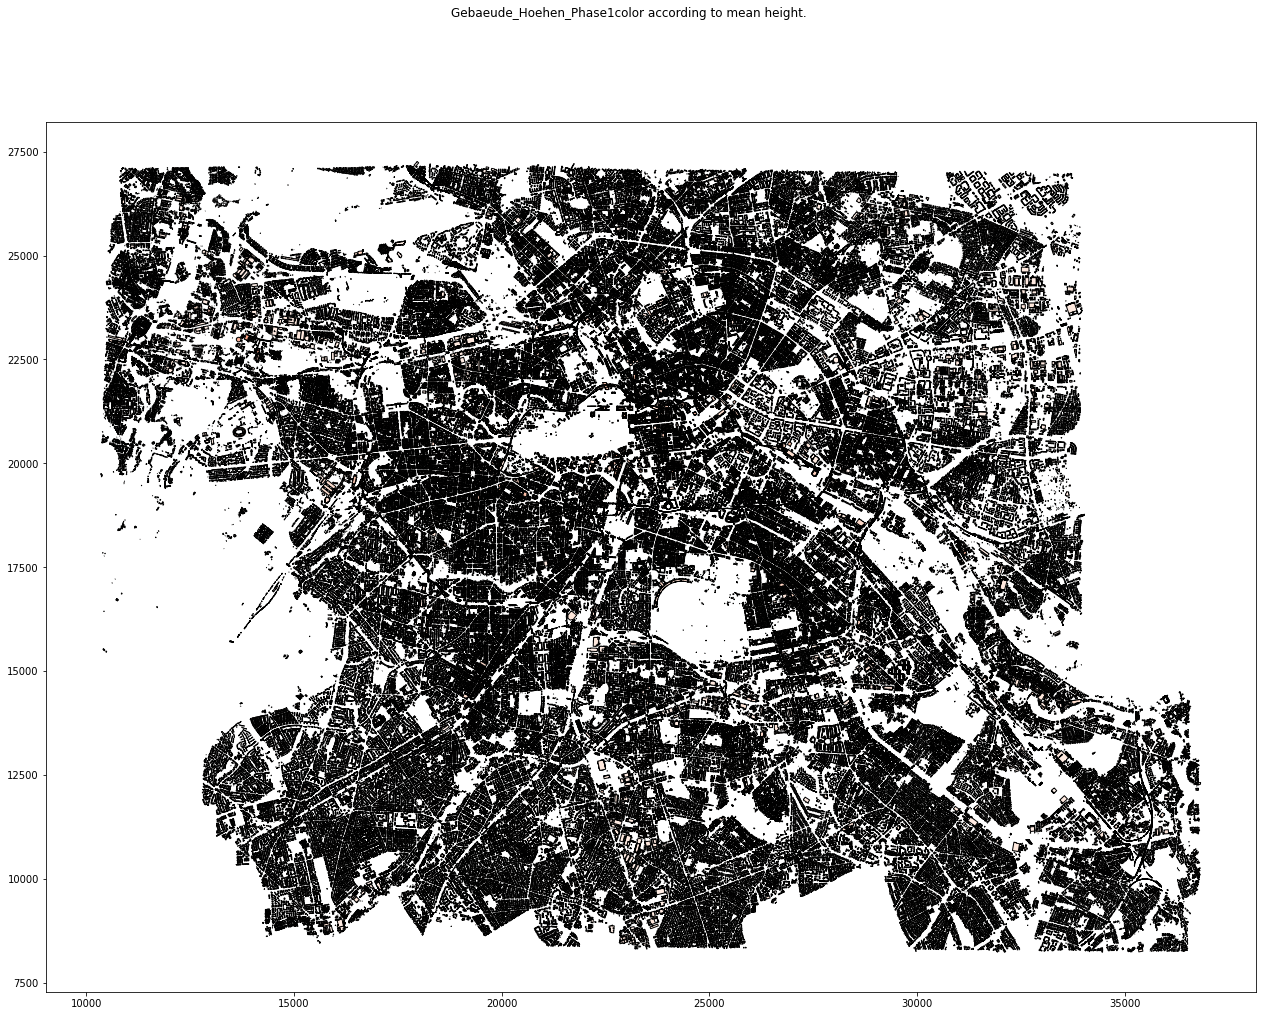

In [ ]:
# %% loop through

# Month day combinations
filenames = ["Gebaeude_Hoehen_Phase1", "Gebaeude_Hoehen_Phase2"]
dates = [[12,21], [3,21], [6,21], [9,21]]
hours = [18, 9]

for filename in filenames:
    print("open ", filename)
    connection = r'./GeoData/' + filename + '.shp'
    # Importing an ESRI Shapefile
    footprint_df = gpd.read_file(connection)
    print("file read.")
    if("Class_name" in footprint_df.columns):
        footprint_df = footprint_df[
            (footprint_df['Mean_nDOM'] > 0) & 
            (footprint_df['Class_name'] != 'Veg < 2,5 m (einschl. Rasen, Grünland)')
        ]
    
    footprint_df['height'] = footprint_df['Mean_nDOM']

    #reproject to obtain proper WGS84 latitude-longitude projection EPSG:4326, 
    # to obtain correct coordinates to retrieve altitude and azimuth
    footprint_df = footprint_df.to_crs(epsg = 4326)
    footprint_df['centroid'] = footprint_df.centroid
    footprint_df['long4326'] = footprint_df['centroid'].x
    footprint_df['lat4326'] = footprint_df['centroid'].y
    
    # reprojecting to DHDN / Soldner Berlin EPSG:3068 with transformation: 1777
    # DHDN: Deutsches Hauptdreiecksnetz
    # https://epsg.io/3068-15949
    footprint_df = footprint_df.to_crs(epsg = 3068)
    
    # plot using GeoPandas and Matplotlib
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (24,16))
    footprint_df.plot(ax=axs, cmap = 'Reds', edgecolor = 'black', column = 'Mean_nDOM')
    fig.suptitle(filename + ': color according to mean height.')


    
    for mmdd in dates:
        for hh in hours:
            shadow_df = footprint_df
            # year, month, day, hour, minute, second, microsecond
            date = datetime(2021, *mmdd, hh, 0, 0, 0, tzinfo=pytz.timezone('Europe/Berlin'))
            altitude = solar.get_altitude(
                latitude_deg = 52.5, 
                longitude_deg = 13.4, 
                when = date
                )
            print("Date:" ,date, "altitude:", altitude)
            if(altitude > 0):
                progress = list(map(lambda x: (len(footprint_df)/100*x)//1, range(1,101)))
                startTime = lastTime =  datetime.now()
                leftOvers = footprint_df.index if not 'i' in locals() else footprint_df.index[i:]
                for i in leftOvers:
                # for i in footprint_df.index:
                    geom = footprint_df.loc[i, 'geometry']#, 
                    height = footprint_df.loc[i, 'height']#,
                    lat = footprint_df.loc[i, 'lat4326']#, 
                    long = footprint_df.loc[i, 'long4326']#
                    method = "difference"#,
                    showPlots = False
                    
                    if(type(geom) != shapely.geometry.polygon.Polygon):
                        continue
                    #
                    
                    (shadow) = projectShadow(
                        geom = geom, 
                        height = height,
                        lat = lat, 
                        long = long, 
                        date = date,
                        method = method,
                        showPlots = showPlots
                        )
                       
                    shadow_df.loc[i, "geometry"] = shadow
                    if(i in progress):
                        print(progress.index(i), "%. Time: ",  datetime.now() - lastTime)
                        lastTime = datetime.now()
                #
                # save as new file
                newFileName = str(filename)+"_"+str(mmdd[0])+"-"+str(mmdd[1])+"_"+str(hh)+".shp"
                print("save to ", newFileName)
                shadow_df.to_file(newFileName)
                
                oneShadowGeom = cascaded_union(shadow_df["geometry"])
                
                # plot using GeoPandas and Matplotlib
                fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (24,16))
                shadow_df.plot(ax=axs, color =  "#ccccccaa")
                footprint_df.plot(ax=axs, cmap = 'Reds', edgecolor = 'black', column = 'Mean_nDOM')
                fig.suptitle(filename + 'color according to mean height.')
                print('Overall time for shadow projection: ', datetime.now() - startTime)
        
# end loop
# print(np.array(perf["manual"]).mean()) # when not silent 0.81s # when silent 0.51s
# print(np.array(perf["polygonize"]).mean()) # when not silent 0.57 # when silent 0.15s
# print(np.array(perf["difference"]).mean()) # when not silent 0. # when silent 0.11s



In [ ]:
i

0

### Merge shadow map into single multipolygon
This can reduce memory space and make operations faster where you check wheter point is within shadow or not

In [ ]:
# %% merge and simplify polygons 

for i in footprint_df.index:
    if(i in progress):
        print(progress.index(i), "%. Time: ",  datetime.now() - lastTime)
        lastTime = datetime.now()
#
                #
                
a = list(map(lambda x: type(x), shadow_df['geometry']))
from itertools import groupby
[len(list(group)) for key, group in groupby(a)]

from shapely.geometry import mapping, Polygon
import fiona

# Here's an example Shapely geometry
df = gpd.GeoSeries([geom])
df.crs = "EPSG:3068"
df = df.to_crs(4326)
poly = geom#Polygon([(0, 0), (0, 1), (1, 1), (0, 0)])

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
with fiona.open('./out/'+newFileName+'ONE'+'.shp', 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(oneShadowGeom),
        'properties': {'id': newFileName},
    })

# Intersecting Layers intersection = gpd.overlay(layer1, layer2, how = 'intersection')
# Union Layers union = gpd.overlay(layer1, layer2, how = 'union')
# how = [
#   'symmetric_difference'= A|B & !A&B, 
#   'difference' = A & !B, 
#   'dissolve' = merge, 
#       first give union common variable with same value union['common_column'] = 1
#       disolve: union_desolved = union.dissolve(by='commun_column')

# shapely:: object.simplify(tolerance, preserve_topology=True) Returns a simplified representation of the geometric object.

# https://geopandas.org/docs/user_guide/geometric_manipulations.html
# https://geopandas.org/docs/user_guide/data_structures.html
# districts_in_aoi['area'] = districts_in_aoi.area/1000000

# Exporting GeoPandas GeoDataFrames into an ESRI Shapefile
# districts_in_aoi.to_file('districts_within_aoi.shp', driver = "ESRI Shapefile")

# Create figures for illustration of method on how shadows are computed

### Shadow of a pole for each date time combination

Date: 2021-06-21 18:00:00+00:53 altitude: 18.623893099082913
Date: 2021-06-21 09:00:00+00:53 altitude: 45.12588180906564


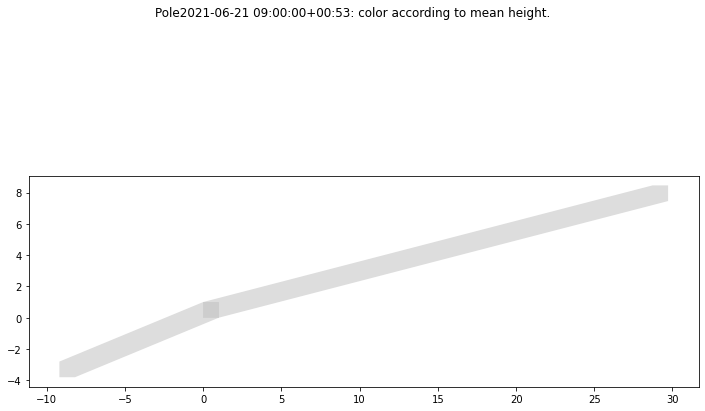

In [ ]:
# 2Do create a figure that shows the shadow of a pole for all times of the day for each date

# Month day combinations
dates = [[12,21], [3,21], [6,21], [9,21]]
hours = [18, 9]

dates = [[6,21]]
hours = [18,9]

ber_lat = 52.5
ber_lon = 13.4

for mmdd in dates:
    shadow_df = gpd.GeoDataFrame(geometry=[Polygon([(ber_lon,ber_lat),(ber_lon+0.001,ber_lat),(ber_lon+0.001,ber_lat+0.001),(ber_lon,ber_lat+0.001)])])
    shadow_df = gpd.GeoDataFrame(geometry=[Polygon([(0,0),(1,0),(1,1),(0,1)])])
    for hh in hours:
        # year, month, day, hour, minute, second, microsecond
        date = datetime(2021, *mmdd, hh, 0, 0, 0, tzinfo=pytz.timezone('Europe/Berlin'))
        altitude = solar.get_altitude(
            latitude_deg = ber_lat, 
            longitude_deg = ber_lon, 
            when = date
            )
        print("Date:" ,date, "altitude:", altitude)
        if(altitude > 0):
            geom = shadow_df.iloc[0]["geometry"]#, 
            height = 10#,
            lat = ber_lat#, 
            long = ber_lon#
            method = "difference"#,
            showPlots = False
            
            if(type(geom) != shapely.geometry.polygon.Polygon):
                continue
            #
            
            (shadow) = projectShadow(
                geom = geom, 
                height = height,
                lat = lat, 
                long = long, 
                date = date,
                method = method,
                showPlots = showPlots
                )
                
            shadow_df = shadow_df.append( gpd.GeoDataFrame(geometry=[shadow]) )
            # save as new file
            #newFileName = "pole_"+str(mmdd[0])+"-"+str(mmdd[1])+"_"+str(hh)+".shp"
            #print("save to ", newFileName)
            #shadow_df.to_file(newFileName)
            
    oneShadowGeom = cascaded_union(shadow_df["geometry"])
        
    # plot using GeoPandas and Matplotlib
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
    shadow_df.plot(ax=axs, color =  "#ccccccaa")
    fig.suptitle("Pole" + str(date) + ': color according to mean height.')
        



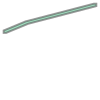

In [ ]:
shadow_df

,geometry
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."
0,"POLYGON ((0.00001 -0.00000, 0.00001 -0.00000, ..."
0,"POLYGON ((-8.19910 -3.80809, -8.19910 -3.80809..."


In [ ]:
shadow_df = gpd.GeoDataFrame(geometry=[Polygon([(0,0),(1,0),(1,1),(0,1)])])
shadow_df

,geometry
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."


In [ ]:
newrow = shadow_df.loc[0]
newrow["geometry"] = Polygon([(0,0),(1,0),(1,1),(0,1)])
shadow_df=shadow_df.append(newrow)

KeyError: 0

In [ ]:
shadow_df

,geometry
0,"POLYGON ((-73.04569 -88.02911, -73.04569 -88.0..."
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."


# speed up code by 
- evaluate wheter set() makes it faster
- don't call fcts from objects like math.fun()
- Use multiple assignments like a, b, c, d = 2, 3, 5, 7
- L = [i for i in range (1, 1000) if i%3 == 0]
- Use proper data structure whereever possible